# Prepare regression models
- Database: Bradley's dataset
- X: fingerprint or vectors made by VAE
- y: Melting temperature, TPSA, or MolLogP

In [3]:
import random
import sys
import pandas as pd
import joblib
import numpy as np

sys.path.append("../lib")
from fp_func import fp_similarity
from JTNNWrapper import JTNNWrapper
from Fingerprint import Fingerprint
from util import extra_split

In [4]:
#load database

file_path="../database/BradleyDoublePlusGoodMeltingPointDataset_logP.csv"
target_param_name="MolLogP"
#target_param_name="TPSA"
#target_param_name="MP"


smiles_column="SMILES"
    
df=pd.read_csv(file_path)
df=df[[smiles_column,target_param_name]]
df=df.dropna()

smiles_list=list(df[smiles_column].values)
y_array=np.array(df[target_param_name].values)

In [5]:
#laod vector expression of molecules

vec_path="data/jtnn_vec"
#jtnn=JTNNWapper()
#vec_array=jtnn.encode(smiles_list)
#joblib.dump(vec_array,vec_path)
vec_array=joblib.load(vec_path)


#prepare vector data df
available_ids=list(set(np.where(vec_array!=0)[0]))
vec_array=vec_array[available_ids]
y_array=y_array[available_ids]
vec_data_df=pd.DataFrame(vec_array)
vec_data_df["y"]=y_array

In [6]:
#prepare FP data df
FP=Fingerprint()

_,available_ids=FP.calc_fingerprint(df[smiles_column].values)
temp_df=df[available_ids]
fp_list,_=FP.calc_fingerprint(temp_df[smiles_column].values)

fp_df=pd.DataFrame(fp_list)
fp_df["y"]=temp_df[target_param_name]

In [7]:
from ScaleRegressor import ScaleRegressor
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.cross_decomposition import PLSRegression
from sklearn import linear_model


def evaluate_model(model, data_df, plot=True):
    tr_X, te_X, tr_y, te_y = extra_split(
        data_df, target_param_name="y",smiles_column=None,
        top_spl_ratio=0.95, spl_ratio=0.9)

    model.fit(tr_X, tr_y)
    p_tr_y = model.predict(tr_X)
    p_te_y = model.predict(te_X)

    if plot:
        plt.figure(figsize=(4, 4))
        plt.scatter(tr_y, p_tr_y, s=3)
        plt.scatter(te_y, p_te_y, s=3)

        vmax = np.max(np.concatenate([tr_y, te_y]))
        vmin = np.min(np.concatenate([tr_y, te_y]))

        plt.xlim(vmin, vmax)
        plt.ylim(vmin, vmax)

    tr_y_max = np.max(tr_y)

    extra_ids = np.where(te_y > tr_y_max)
    inner_ids = np.where(te_y <= tr_y_max)

    extra_MAE = mean_absolute_error(te_y[extra_ids], p_te_y[extra_ids])
    inner_MAE = mean_absolute_error(te_y[inner_ids], p_te_y[inner_ids])
    train_MAE = mean_absolute_error(tr_y, p_tr_y)

    # print(extra_MAE,inner_MAE,train_MAE)

    return extra_MAE, inner_MAE, train_MAE

In [8]:
#model definition    
rfr_model=ScaleRegressor(model=RandomForestRegressor())
pls_model=ScaleRegressor(model=PLSRegression(n_components=30))
lasso_model=ScaleRegressor(model=linear_model.Lasso(alpha=0.01))
bayesian_ridge_model=ScaleRegressor(model=linear_model.BayesianRidge())

# Evaluation
    - evaluate_model inputs a) regression model and b) database
    - evaluate_model returns: MAEs for test (extra  region), test (inner region), and train datasets

(2.259562625516011, 0.4601376163744598, 0.46042493329702977)

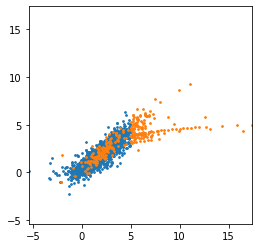

In [9]:
#PLS model and vector type dataframe
evaluate_model(pls_model,vec_data_df)

(3.7387235909127687, 0.533686202972662, 0.4309481081368128)

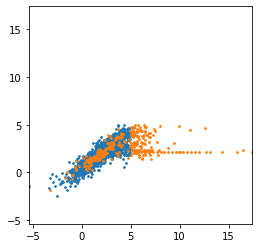

In [10]:
#lasso model and fingerprint type dataframe
evaluate_model(lasso_model,fp_df)

(3.5362258423036583, 0.5180541952550356, 0.38249203595105385)

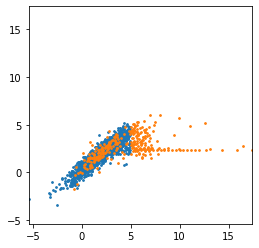

In [11]:
#Bayesian ridge model and fingerprint type dataframe
evaluate_model(bayesian_ridge_model,fp_df)